# EDA for online_retail dataset
#### This notebook provides a high-level overview of the dataset and provides descriptive values and figures about product popularity, etc. It also shifts it to Double-Entry form at the end to make our balance sheet production easier.

#### online_retail was originally an .xlsx file detailing retail invoices from our company. Using the commented code below, this file was converted to a .csv for ease of use. Additional columns 'Month', 'PurchaseTotal', and 'Cancelled' were appended for readability. All transactions were assumed to be done by credit instead of cash.

#### To reconcile the different datasets, timestamps have been shifted up by 11 years to match the Financial/Managerial Accounting datasets

#### TODO:
<ul>
    <li>nicer colors for graphs</li>
</ul>

### Import, setup, and load

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [23]:
online_schema = {
    'InvoiceNo': 'string',
    'StockCode': 'string',
    'Quantity': 'int64',
    'UnitPrice' : 'float64',
    'CustomerID' : 'string',
    'Country' : 'string'
}

schema_de = {
    'InvoiceNo': 'string',
    'InvoiceDate': 'datetime64',
    'Type': 'string',
    'Account': 'string',
    'Amount': 'float64'
}

UK = 'United Kingdom'

In [24]:
online = pd.read_csv('../data/online_retail_sampled.csv', parse_dates=True, dtype=online_schema)
online['InvoiceDate'] = pd.to_datetime(pd.to_datetime(online['InvoiceDate']).dt.date)

### Specifying some handy table projections

In [25]:
online = online.loc[online['InvoiceDate'].dt.year == 2011]
online['PurchaseTotal'] = online['Quantity']*online['UnitPrice']
online['Month'] = online['InvoiceDate'].dt.month
online['InvoiceDate'] = online['InvoiceDate'] + pd.to_timedelta(52*11, unit='W') # Year unit deprecated????? why?????
condition = online['InvoiceNo'].str.contains('C')
online['Cancelled'] = np.where(condition, 1, 0)
online_noCancels = online.loc[online['Cancelled'] == 0]
online_noReturns = online.loc[((online['Quantity'] < 0) & (online['Cancelled'] == 1)) | (online['Quantity'] > 0)]
online_noReturns_noCancels = online.loc[(online['Quantity'] > 0) & (online['Cancelled'] == 0)]
online_noReturns_noCancels_noUK = online_noReturns_noCancels.loc[online_noReturns_noCancels['Country'] != UK]

### Correlation between quantity purchased vs price per unit

In [26]:
stats.pearsonr(online_noReturns_noCancels['Quantity'],online_noReturns_noCancels['UnitPrice']).pvalue

0.5852185166962609

### Correlation between quantity purchased vs price per unit (no UK)

In [27]:
stats.pearsonr(online_noReturns_noCancels_noUK['Quantity'],online_noReturns_noCancels_noUK['UnitPrice']).pvalue

0.06292265663573411

### Is Unit Price a factor in cancellation rates?

In [28]:
prices_cancelled = online_noReturns[online_noReturns['Cancelled'] == 1]['UnitPrice']
prices_fulfilled = online_noReturns[online_noReturns['Cancelled'] == 0]['UnitPrice']
stats.ttest_ind(prices_cancelled, prices_fulfilled, equal_var=False).pvalue

9.212483394721307e-05

### Highest mean quantity per purchase - the item bought in highest quantities (on average) at a time

In [29]:
oNR_MQP = online_noReturns_noCancels[['StockCode','Description','Quantity']]
mqpp = oNR_MQP.groupby(['StockCode','Description']).mean(numeric_only=True)
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].max()]

,StockCode,Description,Quantity
26610,23843,"PAPER CRAFT , LITTLE BIRDIE",80995


### Lowest mean quantity per purchase - the item bought in lowest quantities (on average) at a time

In [30]:
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].min()].set_index('StockCode')

,Description,Quantity
StockCode,,
20761,BLUE PAISLEY SKETCHBOOK,1
20726,LUNCH BAG WOODLAND,1
23358,HOT STUFF HOT WATER BOTTLE,1
23320,GIANT 50'S CHRISTMAS CRACKER,1
22457,NATURAL SLATE HEART CHALKBOARD,1
...,...,...
22613,PACK OF 20 SPACEBOY NAPKINS,1
21524,DOORMAT SPOTTY HOME SWEET HOME,1
22281,EASTER TREE YELLOW BIRDS,1


### Most popular items in each country
#### (Many of the top items are postage (POST), detailless manual entries (M), or shipping (C2). These are excluded from aggregation)

In [31]:
oNRNC = online_noReturns_noCancels # shorthand alias
oNRNC = oNRNC.loc[(oNRNC['StockCode'] != 'POST') & (oNRNC['StockCode'] != 'M') & (oNRNC['StockCode'] != 'C2')]
oNRNC = oNRNC[['Country','StockCode','Description','Quantity']]
oNRNC.groupby(['Country','StockCode','Description']).sum().reset_index()
maxIndices = oNRNC.groupby('Country')['Quantity'].idxmax()
oNRNC[['Country','StockCode','Description','Quantity']].loc[maxIndices].sort_values('Quantity', ascending=False).reset_index().drop('index', axis=1)

,Country,StockCode,Description,Quantity
0,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,Netherlands,23084,RABBIT NIGHT LIGHT,2400
2,Australia,22492,MINI PAINT SET VINTAGE,1152
3,EIRE,84212,"ASSORTED FLOWER COLOUR ""LEIS""",960
4,Sweden,15036,ASSORTED COLOURS SILK FAN,720
5,France,21381,MINI WOODEN HAPPY BIRTHDAY GARLAND,576
6,Spain,84997C,CHILDRENS CUTLERY POLKADOT BLUE,360
7,Austria,21918,SET 12 KIDS COLOUR CHALK STICKS,288
8,Germany,84568,GIRLS ALPHABET IRON ON PATCHES,288
9,Switzerland,84568,GIRLS ALPHABET IRON ON PATCHES,288


### Did some countries cancel more than others?

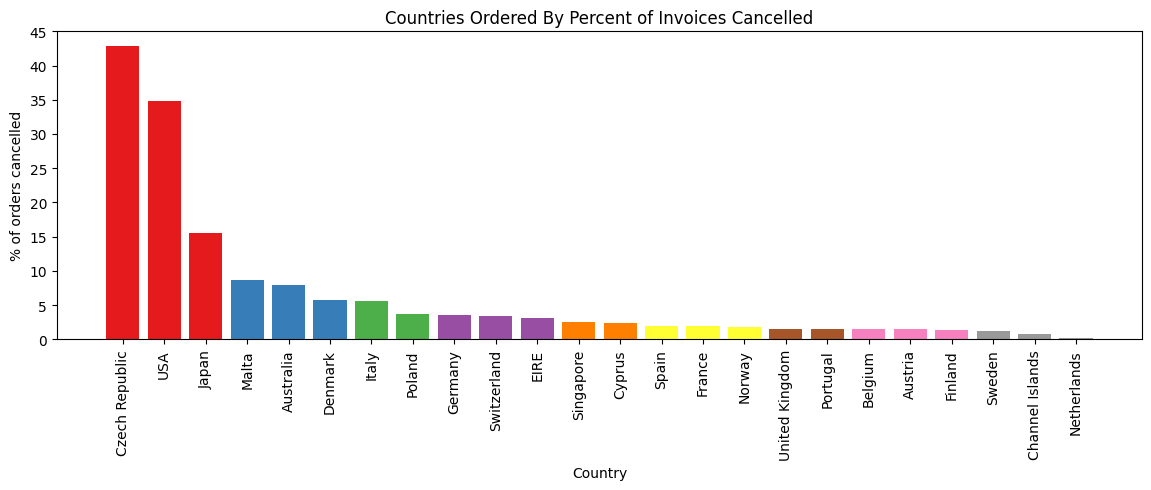

In [32]:
perCountry_All = online_noReturns.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Cancelled = online_noReturns.loc[online_noReturns['Cancelled'] == 1].groupby(['Country', 'Cancelled']).agg(Count=('InvoiceNo', 'count')).reset_index()

joined = perCountry_All.merge(perCountry_Cancelled[['Country','Count']], on='Country', suffixes=('_All','_Cancelled'))
joined['Ratio'] = 100*joined['Count_Cancelled']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders cancelled')
color_range = np.linspace(0,1,len(joined))
plt.title('Countries Ordered By Percent of Invoices Cancelled')
plt.bar(joined['Country'],joined['Ratio'], color=plt.cm.Set1(color_range))
plt.show()

### Did some countries return more than others?

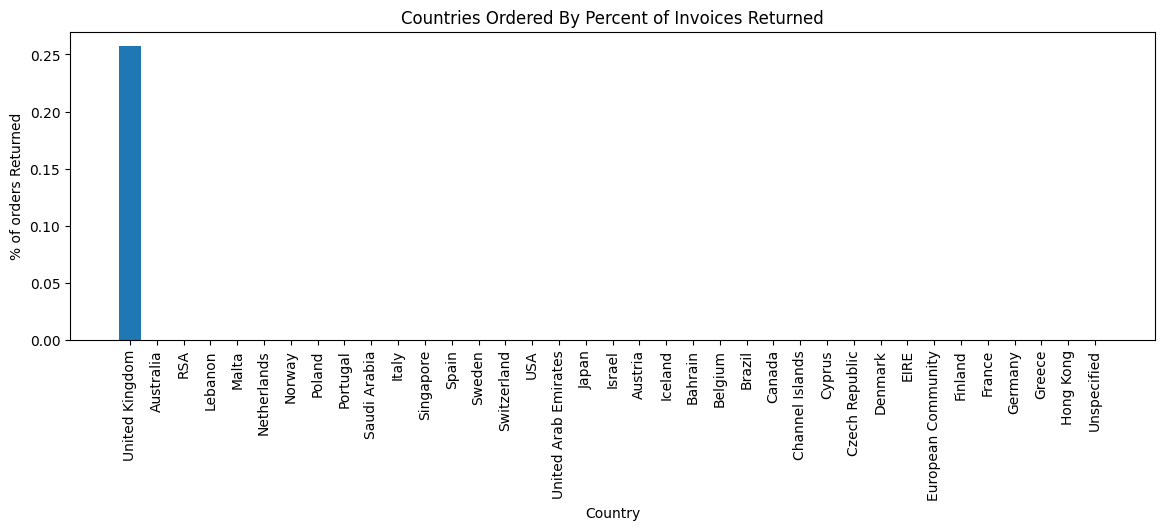

In [33]:
perCountry_All = online_noCancels.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Returned = online_noCancels.loc[online['Quantity'] < 0].groupby(['Country']).agg(Count=('InvoiceNo', 'count')).reset_index()

perCountry_Returned
joined = perCountry_All.merge(perCountry_Returned[['Country','Count']], on='Country', how='left', suffixes=('_All','_Returned')).fillna(0) 
joined['Ratio'] = 100*joined['Count_Returned']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders Returned')
plt.title('Countries Ordered By Percent of Invoices Returned')
plt.bar(joined['Country'],joined['Ratio'])
plt.show()

#### I am willing to bet that returns are only accepted domestically.

### Trend: Net income over time - aggregated by month - 2022 (the only complete year)

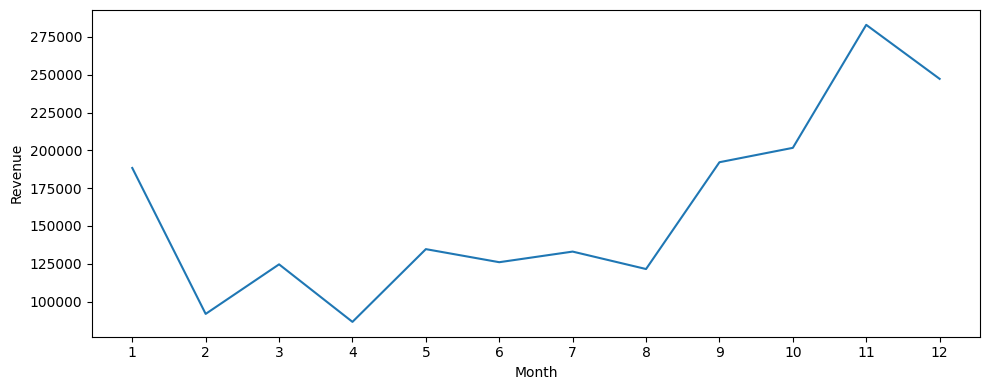

In [34]:
onlineAgg_perMonth = online[['InvoiceDate','Quantity','PurchaseTotal','Month']] \
    .groupby(['Month']).sum(numeric_only=True).reset_index()
plt.figure(figsize=(10,4))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.plot(onlineAgg_perMonth['Month'],onlineAgg_perMonth['PurchaseTotal'])
plt.tight_layout()